ADF Statistic: -0.736087
p-value: 0.837179


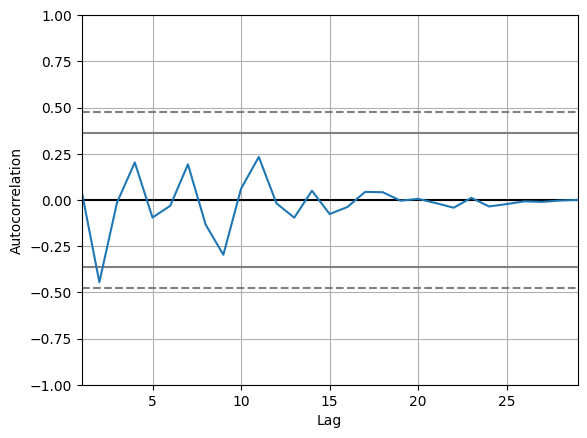

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [2]:
import pandas as pd
import plotly.graph_objs as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Load the dataset
data = pd.read_csv("merged_output.csv", low_memory=False)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

# Convert 'EuroCost' to numeric, forcing invalid entries to NaN
data['EuroCost'] = pd.to_numeric(data['EuroCost'].replace({',': ''}, regex=True), errors='coerce')

# Drop rows with missing EuroCost or Date values
data_clean = data.dropna(subset=['EuroCost', 'Date'])

# Choose a specific NREN, Country, or ServiceType for time series analysis
nren_id = "DFN"  # Example NREN
service_type = "IaaS"  # Example ServiceType

# Filter data for specific NRENID and ServiceType
filtered_data = data_clean[(data_clean['NRENID'] == nren_id) & (data_clean['ServiceType'] == service_type)]

# Group the data by date and sum the EuroCost for that NREN and service type
ts_data = filtered_data.groupby('Date').agg({'EuroCost': 'sum'}).reset_index()

# Set the Date as the index for time series analysis
ts_data.set_index('Date', inplace=True)

# Step 1: Perform an Augmented Dickey-Fuller test to check for stationarity
result = adfuller(ts_data['EuroCost'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# If the p-value is greater than 0.05, the data is not stationary, and we need to difference it
if result[1] > 0.05:
    # Step 2: Apply differencing to make the data stationary
    ts_data['EuroCost_diff'] = ts_data['EuroCost'].diff().dropna()

    # Use the differenced data for Exponential Smoothing modeling
    ts_data.dropna(inplace=True)  # Drop the initial NaN created by differencing
else:
    ts_data['EuroCost_diff'] = ts_data['EuroCost']

# Plot autocorrelation to analyze patterns before fitting the model
autocorrelation_plot(ts_data['EuroCost_diff'])
plt.show()

# Step 3: Fit the Exponential Smoothing model (use additive seasonality)
model = ExponentialSmoothing(ts_data['EuroCost_diff'], seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast for the next 365 days
forecast = model_fit.forecast(steps=365)

# Create a date range for the forecast
future_dates = pd.date_range(start=ts_data.index[-1], periods=365, freq='D')

# Plot with Plotly
fig = go.Figure()

# Add actual data points
fig.add_trace(go.Scatter(x=ts_data.index, y=ts_data['EuroCost_diff'], mode='lines', name='Actual EuroCost'))

# Add forecasted data points
fig.add_trace(go.Scatter(x=future_dates, y=forecast, mode='lines', name='Forecasted EuroCost'))

# Customize the layout
fig.update_layout(
    title=f'EuroCost Forecast for NREN: {nren_id} and ServiceType: {service_type}',
    xaxis_title='Date',
    yaxis_title='EuroCost',
    hovermode='x unified'
)

# Show the plot
fig.show()
